## Testing adding a fault to gempy model


In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

In [2]:
dem_path= os.pardir+"/chloe/DEMraster50_proj_251x200.tif"   #DEM to be used to set model grid (should be rectangular)
intfile = os.pardir+"/chloe/GKgp0101interfaces.csv"
orfile = os.pardir+"/chloe/GKgp0101orientations.csv"

In [3]:

#Manual grid assignment (for debugging):
#if xres=yres, seems to work - but this is incorrect, and why?
#correct values are xres=251, yres=200, zres=26
xmin = 578287.5
xmax = 590837.5
xres = 251                   
dx   = (xmax-xmin)/xres
ymin = 5240062.5
ymax = 5250062.5
yres = 200
dy   = (ymax-ymin)/yres
zmin = 913.0
zmax = 2230.0
zres = 26
dz   = (zmax-zmin)/zres
grid_info = [xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz]  #lump grid and resolution info into one list to use later

print('Grid dimensions:\n', xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz)

Grid dimensions:
 578287.5 590837.5 251 50.0 5240062.5 5250062.5 200 50.0 913.0 2230.0 26 50.65384615384615


[ 578287  590837 5240062 5250062] [200 251]
Cropped raster to geo_model.grid.extent.
[ 578287  590837 5240062 5250062] [200 251]
storing converted file...
obacht


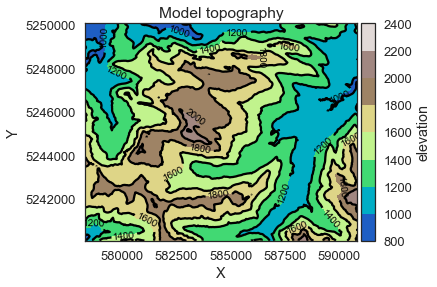

In [4]:
# decreasing model resolution for faster calculation (this does not effect the resolution of dem)
res = [10,12,9]
geo_model = gp.create_model('bla')                                          #create model object
gp.init_data(geo_model, [xmin,xmax, ymin,ymax, zmin,zmax],res,  #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM but must be integers)
            path_o = orfile,                                                  #csv file for orientation points: col names are case sensitive, must include at least one point per unit t
            path_i = intfile)                                                 #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit (except faults)


gp.map_series_to_surfaces(geo_model, {'strat': ('Garschella', 'Schrattenkalk', 'Drusberg')})  #set the correct order of series, youngest to oldest
    
#Set grids:
#geo_model.set_topography(source='gdal', filepath=dem_path)      #load surface topography from DEM
#geo_model.set_topography(source='random')                       #assign random surface topography

#gp.plot.plot_data(geo_model, direction='z') #plot a map view of the data points
#geo_model.surfaces                          #see order of surfaces (series and formations)
#gp.plot.plot_3D(geo_model)                 #display data in 3D using vtk

In [5]:
import matplotlib

In [6]:
#View and set colors for different units (optional):
colordic = {'Garschella':  matplotlib.colors.cnames['saddlebrown'],
          'Schrattenkalk': matplotlib.colors.cnames['yellowgreen'],
          'Drusberg':      matplotlib.colors.cnames['gold'],
          'basement':      matplotlib.colors.cnames['rebeccapurple']} 
geo_model.surfaces.colors.change_colors(colordic)


,surface,series,order_surfaces,isBasement,color,id
0,Drusberg,strat,1,False,#FFD700,1
1,Garschella,strat,2,False,#8B4513,2
2,Schrattenkalk,strat,3,False,#9ACD32,3
3,basement,Basement,1,True,#663399,4


In [9]:
#Calculate model:
gp.set_interpolation_data(geo_model, output='geology', theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


### Set topography: 1) as custom grid, and 2) with gempy function

In [10]:
import gdal
import pandas as pd

In [11]:
dem = gdal.Open(dem_path)

In [12]:
# get xyz surface coordinates
translate_options = gdal.TranslateOptions(options = ['format'],format = "XYZ")  #set options for gdal.Translate()
gdal.Translate('DEMxyz.csv', dem, options=translate_options)  #convert dem to a csv with one column of points, each with an xyz value
xyz = pd.read_csv('DEMxyz.csv', header=None, sep = ' ')       #read xyz csv with pandas
demlist = xyz.values                                          #convert to np array of (x,y,z) values with dim (ncol*nrow, 3)

In [28]:
demlist.shape

(50200, 3)

[ 578287  590837 5240062 5250062] [200 251]
Cropped raster to geo_model.grid.extent.
[ 578287  590837 5240062 5250062] [200 251]
storing converted file...
obacht


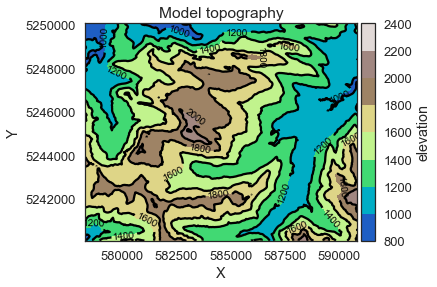

In [47]:
# set topography as custom grid
geo_model.grid.set_custom_grid(demlist)
# set topography with gempy function
geo_model.set_topography(source='gdal', filepath=dem_path)

#### assumption: 
model calculation results of 'custom' and 'topography' grid are similar
#### test:

In [48]:
#compute model with set_solutions=True sets geo_model.solutions 
gp.compute_model(geo_model, set_solutions=True) 


Lithology ids 
  [1. 1. 1. ... 1. 1. 1.] 

In [ ]:
#compute model with set_solutions=False returns sol object 
sol = gp.compute_model(geo_model, set_solutions=False)

in both cases, the solution is calculated for all values in `geo_model.grid.values`, which are the concatenated values of all active grids:

In [49]:
# check which model grids are active
geo_model.grid.grid_types[geo_model.grid.active_grids]

array(['regular', 'custom', 'topography'], dtype='<U10')

In [52]:
# all values
geo_model.grid.values.shape

(101480, 3)

In [62]:
# sum of individual grid values == all values
geo_model.grid.regular_grid.values.shape[0]+geo_model.grid.custom_grid.values.shape[0]+geo_model.grid.topography.values.shape[0]

101480

`geo_model.grid.get_grid_args()` is used to retrieve the individual grid types from the concatenated values by giving start and stop values for slicing the array.

### Manual retrieval of model calculation results:

In [20]:
#### lith block ####
l0, l1 = geo_model.grid.get_grid_args('regular') 
print(l0,l1)
lith_block = sol[0][:, l0: l1]

0 1080


In [37]:
lith_block.shape, geo_model.solutions.lith_block.shape

((1, 1080), (1080,))

In [23]:
### custom grid ###
l0, l1 = geo_model.grid.get_grid_args('custom')
print(l0,l1)
custom = sol[0][:, l0: l1]

1080 51280


In [38]:
custom.shape, geo_model.solutions.custom.shape

((1, 50200), (1, 50200))

In [41]:
### topography grid ###
l0, l1 = geo_model.grid.get_grid_args('topography') # get slicing parameters to obtain only result of custom grid
print(l0,l1)
geomap = sol[0][:, l0: l1] #slice

51280 101480


In [42]:
geomap.shape, geo_model.solutions.geological_map.shape

((1, 50200), (1, 50200))

In [46]:
geomap == geo_model.solutions.geological_map

array([[ True,  True,  True, ...,  True,  True,  True]])

--> it is similar! Maybe the plot is flipped, but in principle the computation is working properly. 

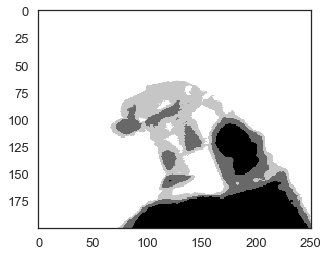

In [44]:
plt.imshow(geo_model.solutions.geological_map.reshape(geo_model.grid.topography.resolution))